[Reference](https://towardsdatascience.com/doping-a-technique-to-test-outlier-detectors-3f6b847ab8d4)

In [3]:
pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-2.0.1-py3-none-any.whl size=193267 sha256=44df07c5a4bdfe5c1173cddd9879324a71c45ada7e451a0f113f3965374149e5
  Stored in directory: /root/.cache/pip/wheels/94/75/88/b853cf33b0053b0a001dca55b74d515048b7656e736364eb57
Successfully built pyod


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


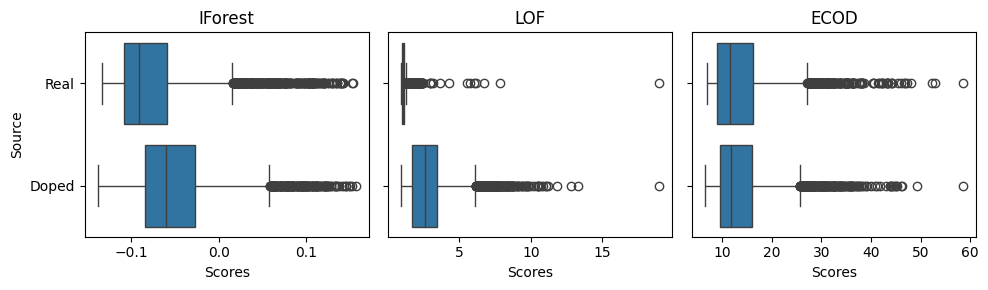

In [4]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns
from pyod.models.iforest import IForest
from pyod.models.lof import LOF
from pyod.models.ecod import ECOD

# Collect the data
data = fetch_openml('abalone', version=1)
df = pd.DataFrame(data.data, columns=data.feature_names)
df = pd.get_dummies(df)
df = pd.DataFrame(RobustScaler().fit_transform(df), columns=df.columns)

# Use an Isolation Forest to clean the data
clf = IForest()
clf.fit(df)
if_scores = clf.decision_scores_
top_if_scores = np.argsort(if_scores)[::-1][:10]
clean_df = df.loc[[x for x in df.index if x not in top_if_scores]].copy()

# Create a set of doped records
doped_df = df.copy()
for i in doped_df.index:
  col_name = np.random.choice(df.columns)
  med_val = clean_df[col_name].median()
  if doped_df.loc[i, col_name] > med_val:
    doped_df.loc[i, col_name] = clean_df[col_name].quantile(np.random.random()/2)
  else:
    doped_df.loc[i, col_name] = \
       clean_df[col_name].quantile(0.5 + np.random.random()/2)

# Define a method to test a specified detector.
def test_detector(clf, title, df, clean_df, doped_df, ax):
  clf.fit(clean_df)
  df = df.copy()
  doped_df = doped_df.copy()
  df['Scores'] = clf.decision_function(df)
  df['Source'] = 'Real'
  doped_df['Scores'] = clf.decision_function(doped_df)
  doped_df['Source'] = 'Doped'
  test_df = pd.concat([df, doped_df])
  sns.boxplot(data=test_df, orient='h', x='Scores', y='Source', ax=ax)
  ax.set_title(title)

# Plot each detector in terms of how well they score doped records
# higher than the original records
fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(10, 3))
test_detector(IForest(), "IForest", df, clean_df, doped_df, ax[0])
test_detector(LOF(), "LOF", df, clean_df, doped_df, ax[1])
test_detector(ECOD(), "ECOD", df, clean_df, doped_df, ax[2])
plt.tight_layout()
plt.show()